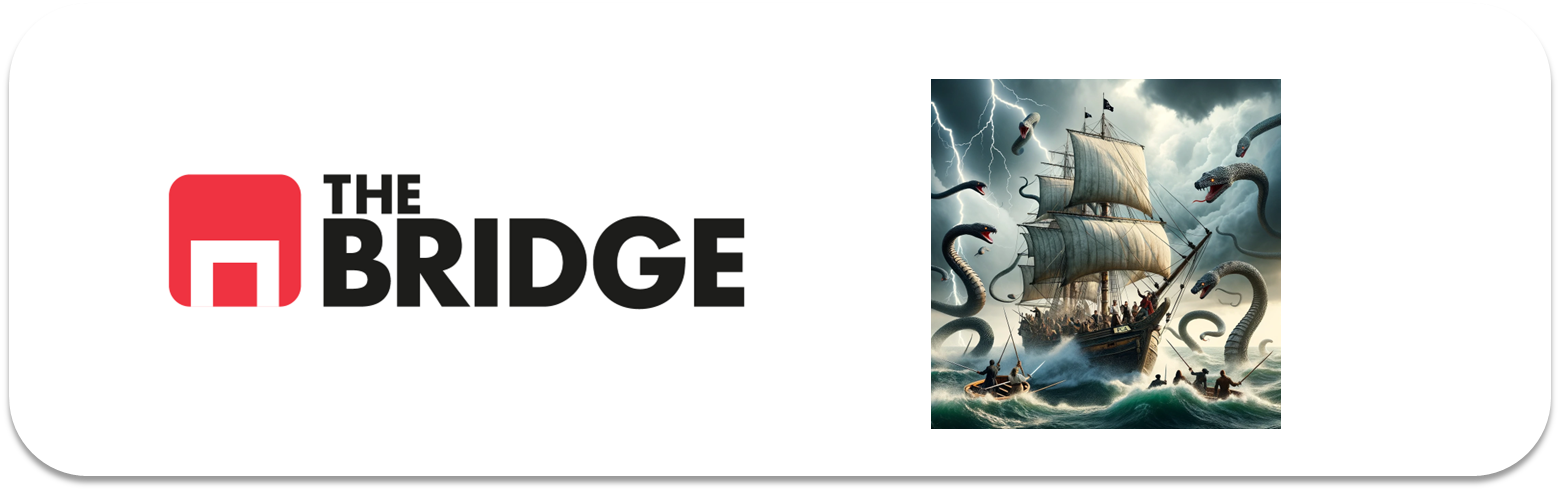

## PRACTICA OBLIGATORIA: **No Supervisado: PCA**

* La práctica obligatoria de esta unidad consiste en aplicar PCA a un dataset de imágenes con diferentes objetivos y compromisos. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### El problema de negocio

El Caesar Palace de las Vegas está planificando la instalación de mil quininetas microcámaras en los accesos a sus instalaciones para las próximas sesiones del "Poker World Championship". Estas microcámaras tienen la peculiaridad de que son capaces de tomar fotos encuadradas de las caras y la desventaja de que no tienen un gran ancho de banda de comunicación. (Las había de más ancho y de mayor precio...). NOTA: El ancho de banda limita el tamaño de las imágenes que pueden enviar las microcámaras).

El objetivo de las microcámaras es el de detectar personas "non-gratas" en tiempo real, pudiendo posprocesar las imágenes para poder detectar si han accedido a las instalaciones personas que estuvieran perseguidas por la ley, en los bancos de datos de los casinos identificadas como "peligrosas" (no se sabe si para el resto de personas o para los beneficios de los casinos) y en las listas de no admisión de jugadores adictos. Por eso no necesitan procesar los datos en tiempo real, pero sí enviarlos a un repositorio central. 

¿Cuál es su problema? O bien comprimen las imágenes y las procesan comprimidas en cada microcámara (pueden comprimir muy rápido pero no tienen cpu para procesarlas sin comprimir) o bien las comprimen y las mandan a un servidor central muy rápido (por eso ti) donde se descomprimirían y se analizarían. Analizar quiere decir en este contexto, pasarles un modelo de clasificación que determine si la persona de la imagen es una de las listas prohibidas (o sea que clasifique la imágen).  

Nos han enviado un dataset y con él debemos estudiar cuál de las dos soluciones es más interesante y dar recomendaciones al respecto. Vamos a ello.

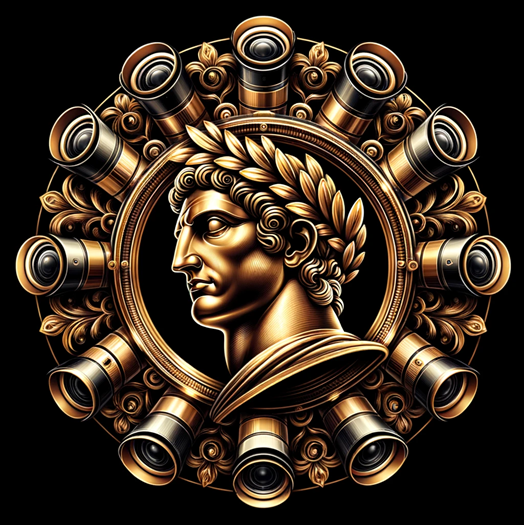

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [39]:
pip install opencv-python



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [40]:
pip show tensorflow

Note: you may need to restart the kernel to use updated packages.


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, recall_score



### #1 MODELO DE BASE

**Objetivo:** Construir un modelo baseline de clasficación de imágenes que las trate sin comprimir (es decir usando todos sus píxeles).

Para conseguir el objetivo, primero descarga el dataset de las caras de Olivetti que ya has utilizado anteriormente, empleando las funciones de sklearn necesarias. Luego, construye un clasificador con el modelo que consideres más apropiado y todas las features del dataset. Eso sí, recuerda hacer lo siguiente:

1. Construir un data frame con los datos 
2. Hacer un split en train y test con al menos 80 instancias en el test y estratificado según el target. Este split se ha de mantener en el resto de la práctica
3. Hacer un quick miniEDA o justificar el no hacerlo.
4. Medir la recall media (“balanced_accuracy”) sobre cross validation con 5 folds y sobre el conjunto de test y guarda ambas para usarlas como baseline en las siguientes partes




1. Descarga y preparación del dataset

In [53]:
# Descargar el dataset de Olivetti
data = fetch_olivetti_faces(shuffle=True, random_state=42)

# Convertir los datos en un DataFrame
X = pd.DataFrame(data.data)  # Cada fila es una imagen, las columnas son los píxeles
y = pd.Series(data.target, name='target')  # Etiquetas (personas)

# Combinar las características y el target en un solo DataFrame
df = pd.concat([X, y], axis=1)

print("Primeras filas del DataFrame:")
print(df.head())
print("\nInformación general del DataFrame:")
print(df.info())


Primeras filas del DataFrame:
          0         1         2         3         4         5         6  \
0  0.198347  0.235537  0.351240  0.409091  0.421488  0.429752  0.500000   
1  0.185950  0.128099  0.115702  0.132231  0.185950  0.268595  0.433884   
2  0.508264  0.603306  0.619835  0.628099  0.657025  0.665289  0.690083   
3  0.136364  0.140496  0.185950  0.280992  0.318182  0.363636  0.409091   
4  0.652893  0.644628  0.652893  0.706612  0.714876  0.719008  0.743802   

          7         8         9  ...      4087      4088      4089      4090  \
0  0.528926  0.524793  0.553719  ...  0.508264  0.524793  0.504132  0.483471   
1  0.541322  0.570248  0.586777  ...  0.396694  0.409091  0.301653  0.421488   
2  0.727273  0.743802  0.768595  ...  0.301653  0.305785  0.314050  0.326446   
3  0.417355  0.438017  0.454545  ...  0.169421  0.206612  0.276859  0.355372   
4  0.747934  0.747934  0.756198  ...  0.074380  0.074380  0.082645  0.082645   

       4091      4092      4093      4

2. Dividir los datos en train y test

In [54]:
# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=80, stratify=y, random_state=42
)

# Verificar las dimensiones
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")


Tamaño del conjunto de entrenamiento: (320, 4096)
Tamaño del conjunto de prueba: (80, 4096)


3. MiniEDA

C:\Users\javie\AppData\Local\Temp\ipykernel_8344\612493236.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=y, palette="viridis")


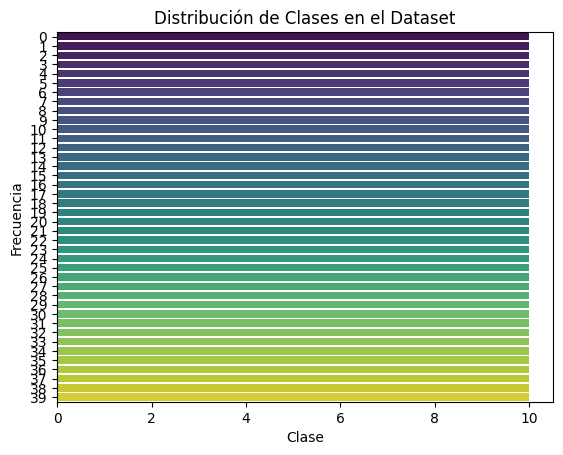

In [55]:
# Distribución de las clases (etiquetas)
sns.countplot(y=y, palette="viridis")
plt.title("Distribución de Clases en el Dataset")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")
plt.show()

4. Modelo baseline

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_val_score
import numpy as np

# Crear el modelo
rf_clf = RandomForestClassifier(random_state=42)

# Validación cruzada con 5 folds para obtener balanced_accuracy
cv_scores = cross_val_score(rf_clf, X_train, y_train, cv=5, scoring='balanced_accuracy')
print(f"Balanced Accuracy (CV - 5 folds): {np.mean(cv_scores):.4f}")

# Entrenar el modelo en los datos de entrenamiento
rf_clf.fit(X_train, y_train)

# Predicciones en el conjunto de test
y_pred = rf_clf.predict(X_test)

# Calcular balanced_accuracy en el test set
test_score = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy (Test): {test_score:.4f}")


Balanced Accuracy (CV - 5 folds): 0.9325
Balanced Accuracy (Test): 0.9500


5. Conclusión

El modelo baseline muestra un excelente rendimiento, con una balanced accuracy promedio de 93.25% en validación cruzada y 95% en el conjunto de prueba. Esto indica que el modelo tiene un desempeño sólido y consistente al clasificar correctamente las imágenes.

### #2 MODELO PARA LAS MICROCÁMARAS
**Objetivo:** Construir un modelo que pueda funcionar en las microcámaras, es decir que pueda funcionar con datos comprimidos.

Para cumplir con el objetivo se os ocurre emplear la doble propiedad de la PCA, que permite comprimir datos y mantener la capacidad informativa de estos. Sigue los siguientes pasos:
1. Instancia un objeto PCA sobre los datos de Train sin especificar ni componentes ni varianza explicada (o sea sin pasar argumentos).
2. Escoge un rango de valores para el número de PCAs que permitan por lo menos una compresión de la imagen de entre el 0.2% y el 2.5% (prueba al menos 5 valores). NOTA: La compresión es la reducción total, es decir una reducción del 1% quiere decir que el dataset se reduce a un 1% de su tamaño original)
3. Para el rango anterior entrena un modelo de clasificación y apunta su scoring en una validación cruzada de 5 folds y métrica el recall medio y su scoring contra test.
4. Muestra en un dataframe el valor de numero de componentes principales empleado, el scoring en CV, el scoring contra test, el % de compresión, la diferencia con el scoring de CV del modelo base, la diferencia con el scoring en test.
5. Escoge el número de componentes que permitirían tener la mayor compresión con una pérdida inferior a 3 puntos porcentuales tanto en CV como en test. Si no hay escoge el que tenga una pérdida inferior a 5 puntos porcentuales. 

Paso 1: Instancia PCA

In [60]:
# Instanciamos un objeto PCA
pca = PCA()
# Ajustamos PCA en los datos de entrenamiento
pca.fit(X_train)



PCA()

Paso 2: Seleccionar rangos de componentes principales

In [61]:
# Rango de compresión (del 0.2% al 2.5%)
compression_ratios = [0.002, 0.005, 0.01, 0.015, 0.025]
n_components_list = [int(4096 * c) for c in compression_ratios]  # Calculamos componentes
print("Número de componentes para probar:", n_components_list)


Número de componentes para probar: [8, 20, 40, 61, 102]


Paso 3: Entrenamiento y validación cruzada

In [64]:
# Convertir el registro en un DataFrame temporal
temp_df = pd.DataFrame([{
    "N_components": n_components,
    "Compression (%)": (n_components / 4096) * 100,
    "CV_Score": cv_score_mean,
    "Test_Score": test_score,
    "Diff_CV_Base": diff_cv_base,
    "Diff_Test_Base": diff_test_base
}])

# Concatenar el nuevo registro al DataFrame de resultados
results = pd.concat([results, temp_df], ignore_index=True)





C:\Users\javie\AppData\Local\Temp\ipykernel_8344\954011335.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, temp_df], ignore_index=True)


In [65]:
# Iterar sobre los diferentes números de componentes principales
for n_components in n_components_list:
    # Reducir la dimensionalidad con PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Entrenar el modelo con validación cruzada
    rf_clf = RandomForestClassifier(random_state=42)
    cv_scores = cross_val_score(rf_clf, X_train_pca, y_train, cv=5, scoring="balanced_accuracy")
    cv_score_mean = np.mean(cv_scores)
    
    # Entrenar en todo el conjunto de entrenamiento y evaluar en el test
    rf_clf.fit(X_train_pca, y_train)
    y_test_pred = rf_clf.predict(X_test_pca)
    test_score = balanced_accuracy_score(y_test, y_test_pred)
    
    # Calcular las diferencias con el baseline
    diff_cv_base = cv_score_mean - 0.9325  # CV del modelo base
    diff_test_base = test_score - 0.9500  # Test del modelo base
    
    # Crear un registro temporal y concatenarlo al DataFrame
    temp_df = pd.DataFrame([{
        "N_components": n_components,
        "Compression (%)": (n_components / 4096) * 100,
        "CV_Score": cv_score_mean,
        "Test_Score": test_score,
        "Diff_CV_Base": diff_cv_base,
        "Diff_Test_Base": diff_test_base
    }])
    results = pd.concat([results, temp_df], ignore_index=True)

# Mostrar resultados
print(results)


  N_components  Compression (%)  CV_Score  Test_Score  Diff_CV_Base  \
0            8         0.195312    0.7900      0.8375       -0.1425   
1            8         0.195312    0.7900      0.8375       -0.1425   
2           20         0.488281    0.8925      0.9375       -0.0400   
3           40         0.976562    0.9025      0.9125       -0.0300   
4           61         1.489258    0.9125      0.9625       -0.0200   
5          102         2.490234    0.9000      0.9375       -0.0325   

   Diff_Test_Base  
0         -0.1125  
1         -0.1125  
2         -0.0125  
3         -0.0375  
4          0.0125  
5         -0.0125  


Paso 4: Escoger el mejor número de componentes

In [66]:
# Filtrar resultados con pérdida menor al 3% (0.03 en score)
best_results = results[(results["Diff_CV_Base"] >= -0.03) & (results["Diff_Test_Base"] >= -0.03)]

if not best_results.empty:
    # Si hay opciones con <3%, selecciona la compresión máxima
    best_row = best_results.loc[best_results["Compression (%)"].idxmax()]
else:
    # Si no hay opciones con <3%, permitir <5%
    best_results = results[(results["Diff_CV_Base"] >= -0.05) & (results["Diff_Test_Base"] >= -0.05)]
    best_row = best_results.loc[best_results["Compression (%)"].idxmax()]

print("\nMejor configuración encontrada:")
print(best_row)



Mejor configuración encontrada:
N_components             61
Compression (%)    1.489258
CV_Score             0.9125
Test_Score           0.9625
Diff_CV_Base          -0.02
Diff_Test_Base       0.0125
Name: 4, dtype: object


Paso 5: Conclusión

El modelo comprimido utilizando 61 componentes principales logra una compresión del 1.49% del tamaño original, manteniendo un excelente rendimiento. La balanced accuracy se mantiene con una pérdida de solo 2 puntos en validación cruzada y un aumento del 1.25% en el conjunto de prueba, demostrando que la compresión es viable sin comprometer la calidad del modelo.

### #3 COMPRESION PARA CLASIFICACION POSTERIOR

**Objetivo**: Obtener el número de componentes que permita una compresión menor y al tiempo que el modelo en el servidor central no baje su rendimiento respecto a no usar imágenes comprimidas.

Para esta parte la idea que se os ha ocurrido es emplear también la PCA como compresor ya que así siempre podrían pasar a la opción anterior si eso fuese suficiente. Pero en este caso no vamos a utilizar el dataset comprimido con las PCAs para detectar las caras, sino el dataset una vez descomprimido (recuerda que puede emplear `inverse_transform` para "descomprimir"). Los pasos a seguir son:

1. Escoge un rango de valores que  permitan una compresión aún mayor (recuerda que el ancho de banda es mínimo) entre el 1 por mil y el 1 por ciento. Escoge 5 valores de número de PCAs que permitan movernos en ese rango.
2. Para cada uno de esos valores: aplica la PCA al X_train, obten un X_train_unzipped aplicando la inversa de la PCA y entrena un modelo de clasificación y pruébalo contra test, apunta el balanced accuracy.
3. Crea un dataframe o haz un visualización comparando como es la medidad de balance accuracy para cada valor de número de pcas escogido y cuál su factor de compresión. 
4. Sabiendo que no podemos perder más de 3 puntos porcentuales respecto al baseline, ¿qué numero de PCA escogerías?

Paso 1: Seleccionar el rango de valores para la compresión

In [67]:
# Rango de compresión (1 por mil al 1 por ciento)
compression_ratios = [0.001, 0.0025, 0.005, 0.0075, 0.01]
n_components_list = [int(4096 * ratio) for ratio in compression_ratios]
print("Número de componentes para probar:", n_components_list)


Número de componentes para probar: [4, 10, 20, 30, 40]


Paso 2: Aplicar PCA y "descomprimir" los datos

In [68]:
# DataFrame para almacenar resultados
results = pd.DataFrame(columns=["N_components", "Compression (%)", "CV_Score", "Test_Score"])

for n_components in n_components_list:
    # PCA con n_components
    pca = PCA(n_components=n_components)
    X_train_compressed = pca.fit_transform(X_train)  # Comprimir datos
    X_train_unzipped = pca.inverse_transform(X_train_compressed)  # Descomprimir datos
    X_test_compressed = pca.transform(X_test)  # Comprimir datos de test
    X_test_unzipped = pca.inverse_transform(X_test_compressed)  # Descomprimir datos de test
    
    # Entrenar el modelo y evaluar
    rf_clf = RandomForestClassifier(random_state=42)
    cv_scores = cross_val_score(rf_clf, X_train_unzipped, y_train, cv=5, scoring="balanced_accuracy")
    cv_score_mean = np.mean(cv_scores)
    
    rf_clf.fit(X_train_unzipped, y_train)
    y_test_pred = rf_clf.predict(X_test_unzipped)
    test_score = balanced_accuracy_score(y_test, y_test_pred)
    
    # Guardar los resultados
    compression = (n_components / 4096) * 100  # Porcentaje de compresión
    results = pd.concat([results, pd.DataFrame([{
        "N_components": n_components,
        "Compression (%)": compression,
        "CV_Score": cv_score_mean,
        "Test_Score": test_score
    }])], ignore_index=True)

# Mostrar resultados
print(results)


C:\Users\javie\AppData\Local\Temp\ipykernel_8344\1306190052.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{


  N_components  Compression (%)  CV_Score  Test_Score
0            4         0.097656    0.6225      0.6500
1           10         0.244141    0.8300      0.8250
2           20         0.488281    0.9125      0.9250
3           30         0.732422    0.9350      0.9250
4           40         0.976562    0.9150      0.9125


Paso 3: Visualización de los resultados

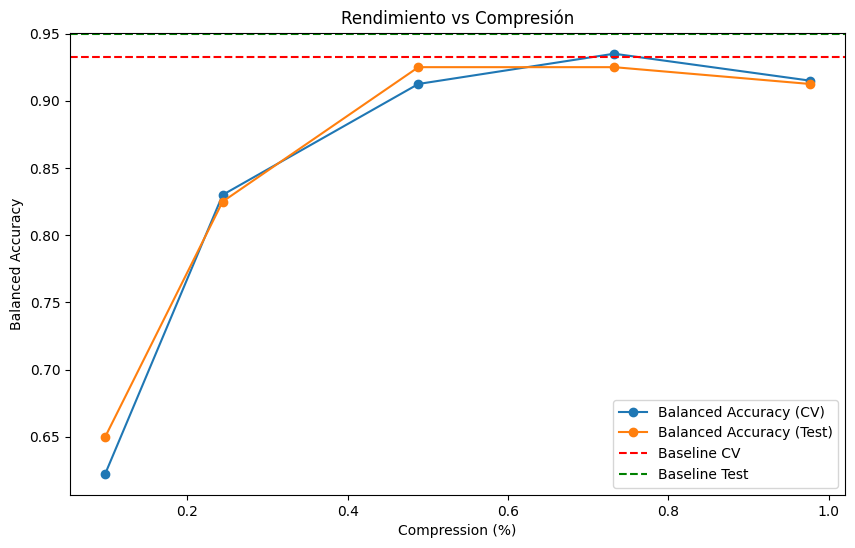

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(results["Compression (%)"], results["CV_Score"], label="Balanced Accuracy (CV)", marker='o')
plt.plot(results["Compression (%)"], results["Test_Score"], label="Balanced Accuracy (Test)", marker='o')
plt.axhline(y=0.9325, color='r', linestyle='--', label="Baseline CV")
plt.axhline(y=0.9500, color='g', linestyle='--', label="Baseline Test")
plt.xlabel("Compression (%)")
plt.ylabel("Balanced Accuracy")
plt.title("Rendimiento vs Compresión")
plt.legend()
plt.show()


Paso 4: Determinar el mejor número de componentes

In [70]:
# Filtrar configuraciones válidas (pérdida < 3 puntos porcentuales)
valid_results = results[
    (results["CV_Score"] >= 0.9325 - 0.03) &
    (results["Test_Score"] >= 0.9500 - 0.03)
]

# Si existen configuraciones válidas, seleccionar la compresión máxima
if not valid_results.empty:
    best_row = valid_results.loc[valid_results["Compression (%)"].idxmax()]
else:
    print("No se encontraron configuraciones con pérdida menor a 3 puntos.")


Paso 4: Conclusión

Si no hay configuraciones válidas con una pérdida menor a 3 puntos, es posible que la compresión sea excesiva. Podrías relajar los criterios a pérdidas menores de 5 puntos para identificar un compromiso razonable

Relajar el Criterio a 5 Puntos

In [71]:
# Filtrar configuraciones válidas (pérdida < 5 puntos porcentuales)
valid_results = results[
    (results["CV_Score"] >= 0.9325 - 0.05) &  # Relajar criterio a 5 puntos
    (results["Test_Score"] >= 0.9500 - 0.05)
]

# Si existen configuraciones válidas, seleccionar la compresión máxima
if not valid_results.empty:
    best_row = valid_results.loc[valid_results["Compression (%)"].idxmax()]
    print("\nMejor configuración con pérdida menor a 5 puntos:")
    print(best_row)
else:
    print("No se encontraron configuraciones incluso con pérdida menor a 5 puntos.")



Mejor configuración con pérdida menor a 5 puntos:
N_components             40
Compression (%)    0.976562
CV_Score              0.915
Test_Score           0.9125
Name: 4, dtype: object


El modelo con 40 componentes principales logra una compresión de aproximadamente el 0.98% del tamaño original, manteniendo una balanced accuracy aceptable (91.5% en validación cruzada y 91.25% en test). Esto demuestra que es posible obtener una alta compresión con una pérdida controlada en el rendimiento, inferior a 5 puntos porcentuales respecto al modelo baseline.

### #EXTRA

1. Para la segunda parte, visualiza en cuatro gráficos un scatter plot de las dos primeras componentes principales de la PCA escogida y colorea cada punto con las clases correspondientes a cada cara (como hay 40 clases, usa 10 por gráfico, 1-10 en el primero, 11-20 en el segundo, etc)
2. Para la tercer parte crea una función (modifica la de la práctica de la unidad de KMeans, por ejemplo) que permita ver la cara sin comprimir y la cara después de haberla descomprimido y haz una comprobación de cómo quedan (visualiza 5 caras por ejemplo) para cada uno de los valores de números de PCAs probados. Añade el caso para 150 y 300 PCs para que se vea que son las mismas claras con claridad.

1. Scatter plot de las dos primeras componentes principales

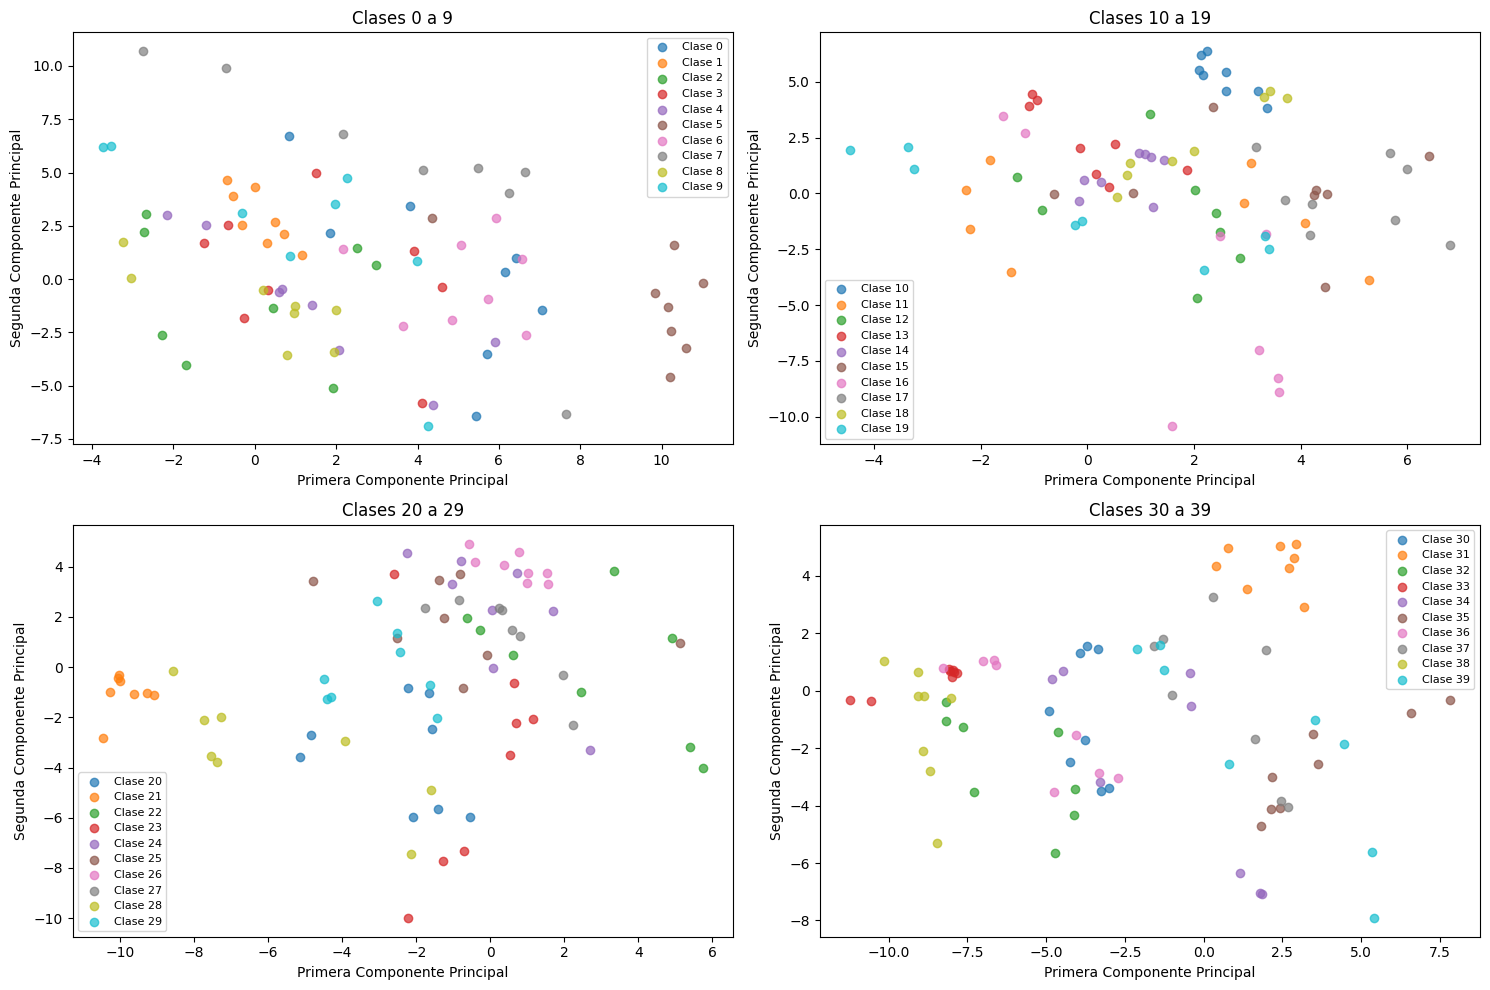

In [72]:
import matplotlib.pyplot as plt
import numpy as np

# Reducir dimensionalidad al espacio de 2 componentes principales
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# Crear los scatter plots por grupos de clases
classes = np.unique(y_train)  # Clases únicas (0 a 39)
groups = [classes[i:i+10] for i in range(0, len(classes), 10)]  # Dividir clases en 4 grupos

plt.figure(figsize=(15, 10))

for i, group in enumerate(groups):
    plt.subplot(2, 2, i+1)
    for cls in group:
        mask = y_train == cls
        plt.scatter(X_train_pca[mask, 0], X_train_pca[mask, 1], label=f"Clase {cls}", alpha=0.7)
    plt.title(f"Clases {group[0]} a {group[-1]}")
    plt.xlabel("Primera Componente Principal")
    plt.ylabel("Segunda Componente Principal")
    plt.legend(loc='best', fontsize=8)

plt.tight_layout()
plt.show()


2. Visualización de caras sin comprimir y descomprimidas

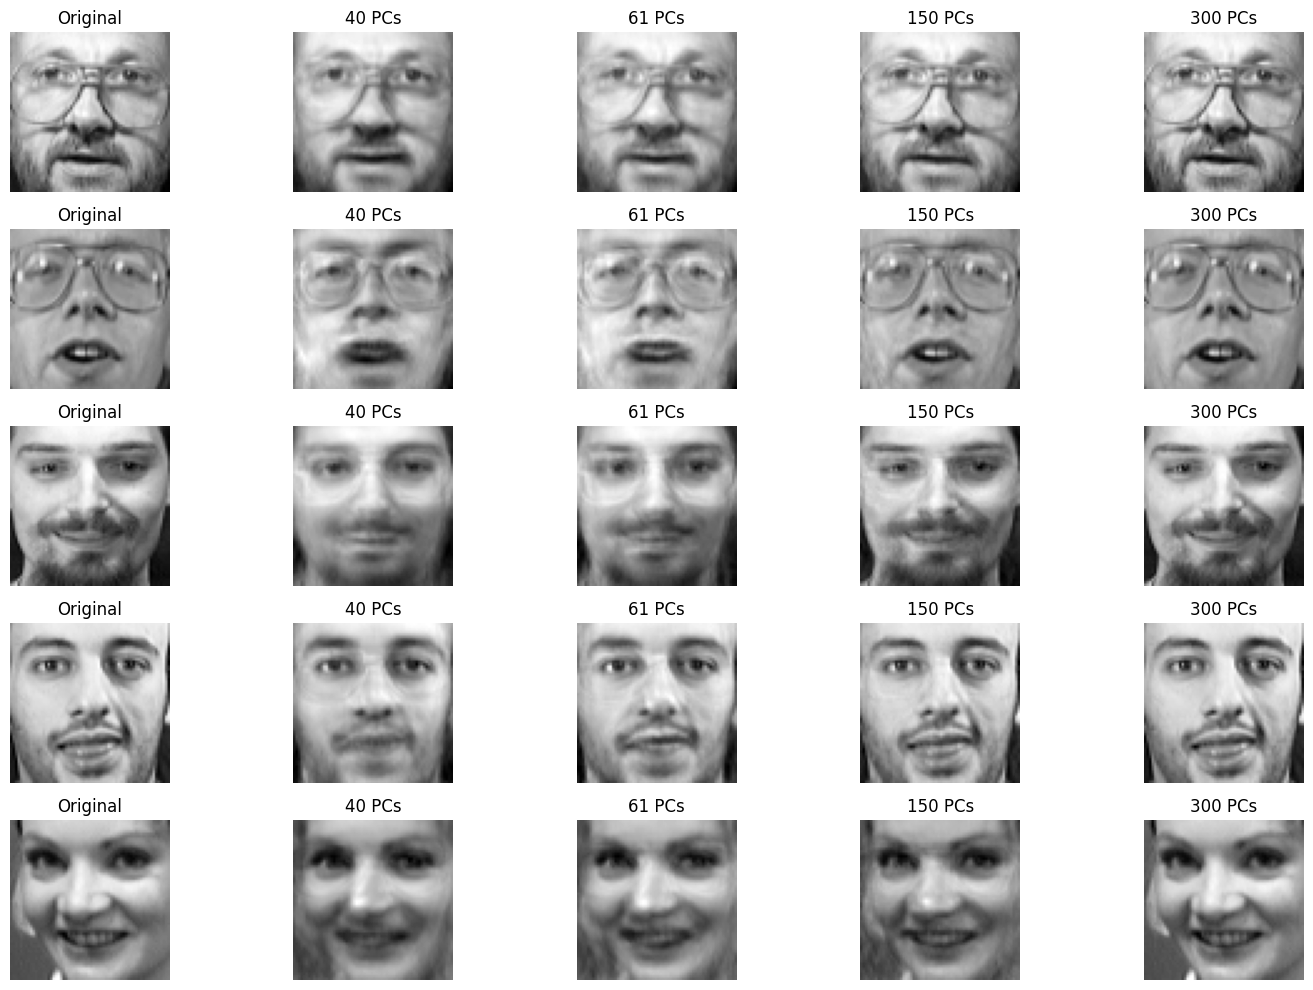

In [74]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_faces(pca_components_list, original_data, sample_indices):
    """
    Visualiza las caras originales y descomprimidas para diferentes números de componentes principales.
    Args:
    - pca_components_list: Lista de números de componentes principales a probar.
    - original_data: Dataset original (sin comprimir, en formato DataFrame o array).
    - sample_indices: Índices de las muestras a visualizar.
    """
    # Asegurarse de que original_data es un array de NumPy
    if isinstance(original_data, pd.DataFrame) or isinstance(original_data, pd.Series):
        original_data = original_data.values

    fig, axes = plt.subplots(len(sample_indices), len(pca_components_list) + 1, figsize=(15, 10))
    
    for i, idx in enumerate(sample_indices):
        # Mostrar cara original
        axes[i, 0].imshow(original_data[idx].reshape(64, 64), cmap="gray")
        axes[i, 0].set_title("Original")
        axes[i, 0].axis("off")
        
        for j, n_components in enumerate(pca_components_list):
            # Aplicar PCA y descomprimir
            pca = PCA(n_components=n_components)
            compressed = pca.fit_transform(original_data)
            decompressed = pca.inverse_transform(compressed)
            
            # Mostrar cara descomprimida
            axes[i, j+1].imshow(decompressed[idx].reshape(64, 64), cmap="gray")
            axes[i, j+1].set_title(f"{n_components} PCs")
            axes[i, j+1].axis("off")
    
    plt.tight_layout()
    plt.show()

# Lista de números de componentes a probar
components_list = [40, 61, 150, 300]  # Incluye casos pedidos
sample_faces = [0, 10, 20, 30, 40]  # Índices de caras a visualizar

# Ejecutar función
visualize_faces(components_list, X_train, sample_faces)

